# Getting started with HuracanPy
In this notebook, we demonstrate the type of analysis workflow you can build using HuracanPy. To know more about the available options and functions, please go through the [huracanpy.load guide](index.rst), and/or browse the [API documentation](../api/index.rst). The [example gallery](../examples/index.rst) gallery also provides useful demonstrations.
We show three workflows: 
1. Studying a specific cyclone
2. Studying a set of tracks
3. Comparing a set of detected/modelled tracks to an observationnal reference

In [1]:
import huracanpy

import matplotlib.pyplot as plt
import seaborn as sns

## 1. Studying a specific cyclone
In this example, we want to study hurricane Wilma (the deepest Atlantic hurricane on record).

### 1a. Load IBTrACS and subset the specific hurricane
Two subsets of IBTrACS are embedded within HuracanPy: WMO and JTWC. 
You can also retrieve the full and last IBTrACS file from the online website. 
Default behavior is loading the embedded WMO subset. For more information, see [huracanpy.load guide](load.ipynb).

In [2]:
# Here we load the WMO subset. This raises a warning that reminds you of the main caveats. 
ib = huracanpy.load(source = "ibtracs")
## The tracks are loaded as an xarray.Dataset, with one dimension "record" corresponding to each point. 
## Variables indicate position in space and time, as well as additional attributes such as maximum wind speed and minimum slp.
ib 

/Users/bourdin/Softs/huracanpy/huracanpy/_data/ibtracs.py:112: UserWarning: This offline function loads a light version of IBTrACS which is embedded within the package, based on a file produced manually by the developers.
                  It was last updated on the 15th Nov 2024, based on the IBTrACS file at that date.
                  It contains only data from 1980 up to the last year with no provisional tracks. All spur tracks were removed. Only 6-hourly time steps were kept.
  warnings.warn(
/Users/bourdin/Softs/huracanpy/huracanpy/_data/ibtracs.py:118: UserWarning: You are loading the IBTrACS-WMO subset.                       This dataset contains the positions and intensity reported by the WMO agency responsible for each basin
                      Be aware of the fact that wind and pressure data is provided as they are in IBTrACS,                       which means in particular that wind speeds are in knots and averaged over different time periods.
                    For more

<xarray.Dataset> Size: 15MB
Dimensions:   (record: 143287)
Dimensions without coordinates: record
Data variables:
    track_id  (record) <U13 7MB '1980001S13173' ... '2022356N09085'
    season    (record) int64 1MB 1980 1980 1980 1980 ... 2022 2022 2022 2022
    basin     (record) <U2 1MB 'SP' 'SP' 'SP' 'SP' 'SP' ... 'NI' 'NI' 'NI' 'NI'
    time      (record) datetime64[ns] 1MB 1980-01-01 ... 2022-12-25T06:00:00
    lon       (record) float64 1MB 172.5 172.4 172.5 172.8 ... 82.5 82.2 81.6
    lat       (record) float64 1MB -12.5 -11.9 -11.5 -11.2 ... 9.7 9.3 9.0 8.5
    wind      (record) float64 1MB nan nan nan nan 30.0 ... 25.0 25.0 25.0 25.0
    slp       (record) float64 1MB nan nan nan ... 1.004e+03 1.004e+03 1.004e+03

In [3]:
# Wilma corresponds to index 2005289N18282, so we subset this storm. There are two ways of doing this:
# 1. Use warray's where
Wilma = ib.where(ib.track_id == "2005289N18282", drop = True)
# 2. Use huracanpy's sel_id method (more efficient and shorter, but does the same thing)
# Note: the `.hrcn` is called an accessor, and allows you to call HuracanPy functions as methods on the xarray objects.
Wilma = ib.hrcn.sel_id("2005289N18282")
# The Wilma object contains only the data for Wilma:
Wilma

<xarray.Dataset> Size: 5kB
Dimensions:   (record: 45)
Dimensions without coordinates: record
Data variables:
    track_id  (record) <U13 2kB '2005289N18282' ... '2005289N18282'
    season    (record) int64 360B 2005 2005 2005 2005 ... 2005 2005 2005 2005
    basin     (record) <U2 360B 'NA' 'NA' 'NA' 'NA' 'NA' ... 'NA' 'NA' 'NA' 'NA'
    time      (record) datetime64[ns] 360B 2005-10-15T18:00:00 ... 2005-10-26...
    lon       (record) float64 360B -78.5 -78.8 -79.0 ... -57.5 -55.0 -52.0
    lat       (record) float64 360B 17.6 17.6 17.5 17.5 ... 42.5 44.0 45.0 45.5
    wind      (record) float64 360B 25.0 25.0 30.0 30.0 ... 60.0 55.0 50.0 40.0
    slp       (record) float64 360B 1.004e+03 1.004e+03 ... 986.0 990.0

### 1b. Add category info
You can add the Saffir-Simpson and/or the pressure category of Wilma to the tracks (for full list of available info, see [huracanpy.info](../api/huracanpy.info.rst)).

In [4]:
# Add Saffir-Simpson Category
Wilma = Wilma.hrcn.add_saffir_simpson_category(wind_name = "wind", wind_units = "knots")
Wilma.saffir_simpson_category # This is stored in the `saffir_simpson_category` variable

Magnitude,[-1 -1 -1 -1 -1 -1 0 0 0 0 1 1 2 5 5 5 5 5 5 5 5 5 5 5 4 4 4 3 2 2 2 2 3 3 4 3 4 4 3 3 2 1 0 0 0]
Units,dimensionless


In [5]:
# Add pressure category
Wilma = Wilma.hrcn.add_pressure_category(slp_name = "slp")
Wilma.pressure_category

<xarray.DataArray 'pressure_category' (record: 45)> Size: 360B
array([0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 2, 3, 5, 5, 5, 5, 5, 5, 5, 5,
       4, 4, 4, 4, 4, 3, 3, 3, 2, 2, 2, 3, 3, 3, 3, 3, 2, 2, 1, 1, 1, 1,
       1])
Dimensions without coordinates: record
Attributes:
    units:    dimensionless

In [6]:
# Note: Most of the accessor methods have a get_* and an add_* version. 
# get_ return the values of what you ask for as a DataArray, while add_ adds it directly to the dataset with a default name. 
# In the previous case, we could have called get_pressure_category
Wilma.hrcn.get_pressure_category(slp_name = "slp")
# we could then save it as a variable, and potentially add it to the dataset separately

<xarray.DataArray (record: 45)> Size: 360B
array([0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 2, 3, 5, 5, 5, 5, 5, 5, 5, 5,
       4, 4, 4, 4, 4, 3, 3, 3, 2, 2, 2, 3, 3, 3, 3, 3, 2, 2, 1, 1, 1, 1,
       1])
Dimensions without coordinates: record
Attributes:
    units:    dimensionless

### 1c. Plot the track and its evolution

(<Figure size 1000x1000 with 1 Axes>, <GeoAxes: xlabel='lon', ylabel='lat'>)

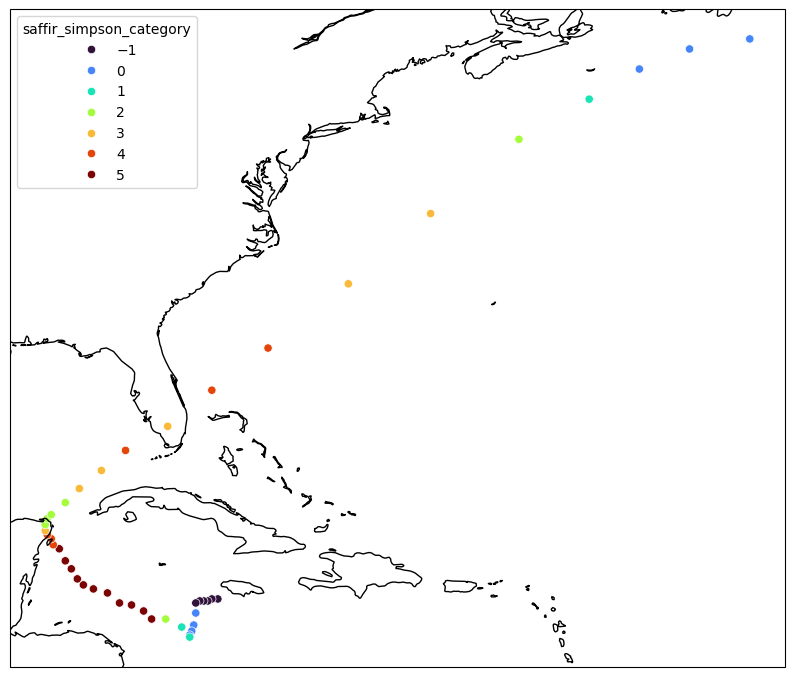

In [7]:
# Plot the track on a map, colored by Saffir-Simpson category
Wilma.hrcn.plot_tracks(intensity_var_name = "saffir_simpson_category", scatter_kws = {"palette": "turbo"})

Text(0, 0.5, 'SLP / hPa')

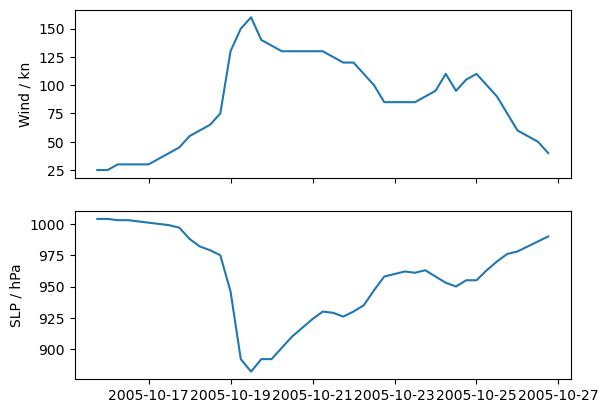

In [8]:
# Plot intensity time series using matplotlib
fig, axs = plt.subplots(2, sharex = True)
axs[0].plot(Wilma.time, Wilma.wind)
axs[1].plot(Wilma.time, Wilma.slp)
axs[0].set_ylabel("Wind / kn")
axs[1].set_ylabel("SLP / hPa")

### 1d. Calculate properties 

#### Duration

In [9]:
Wilma.hrcn.get_track_duration() # Note duration is in h

<xarray.DataArray 'duration' (track_id: 1)> Size: 8B
array([264.])
Coordinates:
  * track_id  (track_id) object 8B '2005289N18282'
Attributes:
    units:    hours

#### ACE

In [10]:
## Compute ACE for each point
Wilma = Wilma.hrcn.add_ace(wind_units = "knots")
Wilma.ace

<xarray.DataArray 'ace' (record: 45)> Size: 360B
array([0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.1225, 0.16  ,
       0.2025, 0.3025, 0.36  , 0.4225, 0.5625, 1.69  , 2.25  , 2.56  ,
       1.96  , 1.8225, 1.69  , 1.69  , 1.69  , 1.69  , 1.69  , 1.5625,
       1.44  , 1.44  , 1.21  , 1.    , 0.7225, 0.7225, 0.7225, 0.7225,
       0.81  , 0.9025, 1.21  , 0.9025, 1.1025, 1.21  , 1.    , 0.81  ,
       0.5625, 0.36  , 0.3025, 0.25  , 0.16  ])
Dimensions without coordinates: record
Attributes:
    units:    knot ** 2

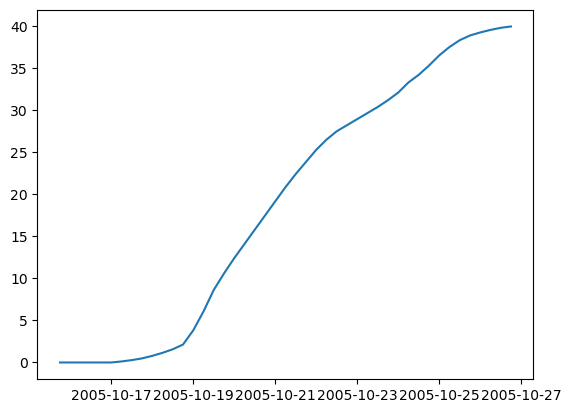

In [11]:
## Plot cumulated ACE
plt.plot(Wilma.time, Wilma.ace.cumsum())

#### Translation speed

Text(0, 0.5, 'Translation speed / m/s')

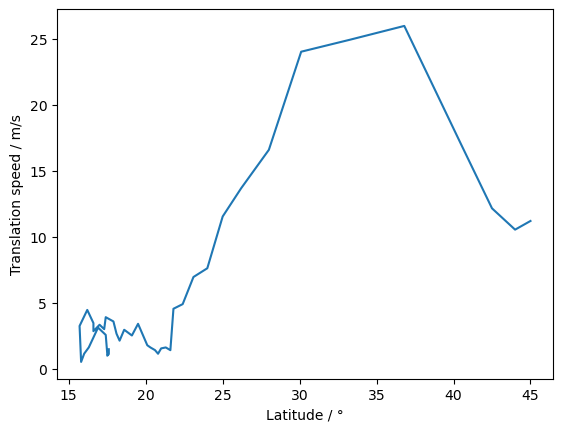

In [12]:
# Compute translation speed
Wilma = Wilma.hrcn.add_translation_speed()
# Plot translation speed against latitude
plt.plot(Wilma.lat, Wilma.translation_speed)
plt.xlabel("Latitude / °")
plt.ylabel("Translation speed / m/s")

#### Intensification rate

In [13]:
# Add intensification rate in wind and pressure
Wilma = Wilma.hrcn.add_rate(var_name = "wind")
Wilma = Wilma.hrcn.add_rate(var_name = "slp")
# NB: The rates will be in unit/s, where unit is the unit of the variable.

Text(0, 0.5, 'hPa/h')

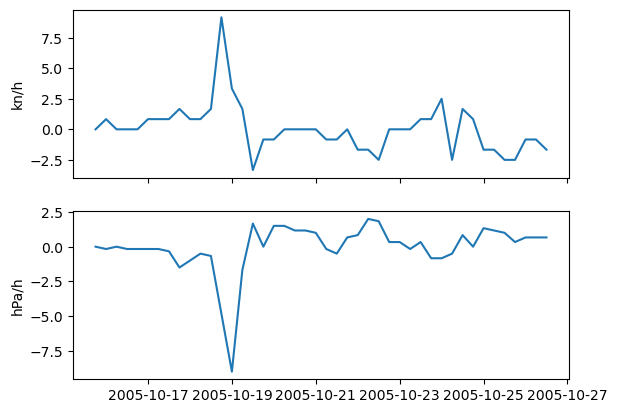

In [14]:
# Plot intensity time series
fig, axs = plt.subplots(2, sharex = True)
axs[0].plot(Wilma.time, Wilma.rate_wind * 3600) # Convert to kn/h
axs[1].plot(Wilma.time, Wilma.rate_slp * 3600) # Convert to hPa/h
axs[0].set_ylabel("kn/h")
axs[1].set_ylabel("hPa/h")

## 2. Studying a set of tracks

### 2a. Loading data
Here we show an example with a csv file that is embedded within HuracanPy for example. HuracanPy supports many track files format, see [huracanpy.load guide](load.ipynb).

In [16]:
# Loading the ERA5 1996 TC tracks
## The tracks detected by TempestExtremes in ERA5 for the year 1996 are embedded within the package as an example.
file = huracanpy.example_year_file
print(file)
## Load the tracks with huracanpy.load. 
## Here the file extension is '.csv', the function will automatically recognise how to open it.
tracks = huracanpy.load(file)
## The tracks are loaded as an xarray.Dataset, with one dimension "record" corresponding to each point. 
## Variables indicate position in space and time, as well as additional attributes such as maximum wind speed and minimum slp.
tracks

/Users/bourdin/Softs/huracanpy/huracanpy/_data/example_data/ERA5_1996_UZ.csv


<xarray.Dataset> Size: 236kB
Dimensions:   (record: 2274)
Dimensions without coordinates: record
Data variables: (12/13)
    track_id  (record) float64 18kB 1.207e+03 1.207e+03 ... 1.294e+03 1.295e+03
    year      (record) float64 18kB 1.996e+03 1.996e+03 ... 1.996e+03 1.996e+03
    month     (record) float64 18kB 1.0 1.0 1.0 1.0 1.0 ... 12.0 12.0 12.0 12.0
    day       (record) float64 18kB 3.0 3.0 3.0 3.0 4.0 ... 31.0 31.0 31.0 31.0
    hour      (record) float64 18kB 0.0 6.0 12.0 18.0 0.0 ... 6.0 12.0 18.0 18.0
    i         (record) float64 18kB 549.0 550.0 550.0 ... 737.0 754.0 540.0
    ...        ...
    lon       (record) float64 18kB 137.2 137.5 137.5 ... 184.2 188.5 135.0
    lat       (record) float64 18kB -15.5 -15.25 -14.75 ... -47.0 -48.5 -12.5
    slp       (record) float64 18kB 1.006e+05 1.002e+05 ... 9.848e+04 1.005e+05
    zs        (record) float64 18kB 52.12 13.98 32.58 ... -124.6 -128.8 44.54
    wind10    (record) float64 18kB 9.561 11.16 11.03 ... 21.39 21.11 11.58
    time      (record) datetime64[ns] 18kB 1996-01-03 ... 1996-12-31T18:00:00

### 2b. Adding info to the tracks
HuracanPy has several function to add useful information to the tracks (for full list, see [huracanpy.info](../api/huracanpy.info.rst)). Here for example we add basin and SSHS category information.

In [18]:
# Add basin
tracks = tracks.hrcn.add_basin() # Add basin attribute
tracks.basin

<xarray.DataArray 'basin' (record: 2274)> Size: 36kB
array(['AUS', 'AUS', 'AUS', ..., 'SP', 'SP', 'AUS'], dtype='<U4')
Dimensions without coordinates: record

<Axes: xlabel='count'>

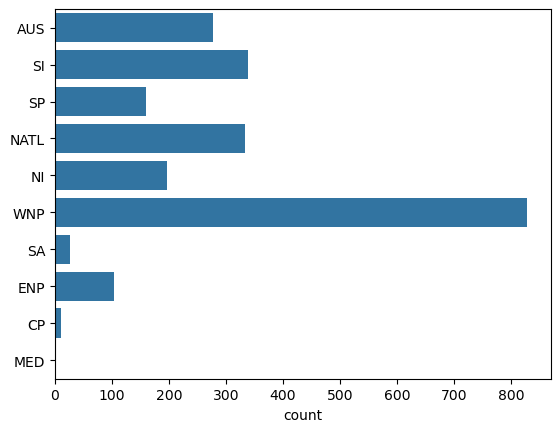

In [19]:
# Show distribution of TC points among basins (calling seaborn function, works better with categorical labels)
import seaborn as sns
sns.countplot(tracks.basin) 

In [25]:
# Add SSHS and pressure categories
tracks = tracks.hrcn.add_saffir_simpson_category(wind_name = "wind10", wind_units='m s-1') 
tracks = tracks.hrcn.add_pressure_category(slp_name = "slp",) 
## (In ERA5 data, wind is stored in wind10 in m/s)
tracks[["saffir_simpson_category", "pressure_category"]]

Magnitude,[-1 -1 -1 ... 0 0 -1]
Units,dimensionless


(array([ 190., 1342.,  534.,  157.,   41.,   10.,    0.]),
 array([-1.5, -0.5,  0.5,  1.5,  2.5,  3.5,  4.5,  5.5]),
 <BarContainer object of 7 artists>)

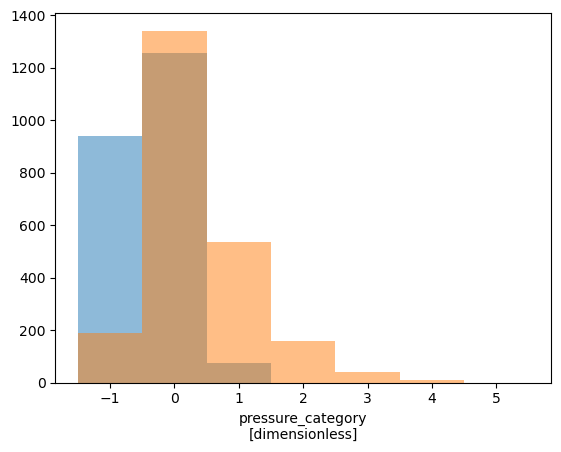

In [28]:
# Show distribution of TC points among categories (using xarray's built-in function)
tracks.saffir_simpson_category.plot.hist(bins = [-1.5, -0.5,  0.5,  1.5,  2.5,  3.5,  4.5,  5.5], alpha = 0.5)
tracks.pressure_category.plot.hist(bins = [-1.5, -0.5,  0.5,  1.5,  2.5,  3.5,  4.5,  5.5], alpha = 0.5)

### 2c. Plotting
HuracanPy embeds basic plotting functions, which are mainly meant for having a preliminary look at your data. In particular here we show how to plot the track points themselves, and track density. You can learn more in the [huracanpy.plot guide](plot.ipynb). The [example gallery](../examples/index.rst)  also displays nice plots made from HuracanPy and the associated scripts.
#### Plotting the tracks

(<Figure size 1000x1000 with 1 Axes>, <GeoAxes: xlabel='lon', ylabel='lat'>)

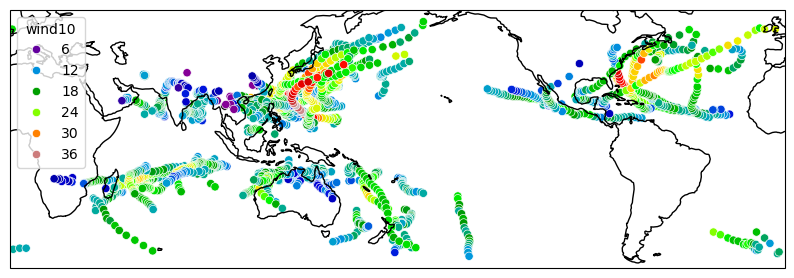

In [7]:
# Plot ERA5 tracks colored by wind intensity
tracks.hrcn.plot_tracks(intensity_var_name = "wind10",)

#### Plotting track density

(<Figure size 640x480 with 2 Axes>, <GeoAxes: xlabel='lon', ylabel='lat'>)

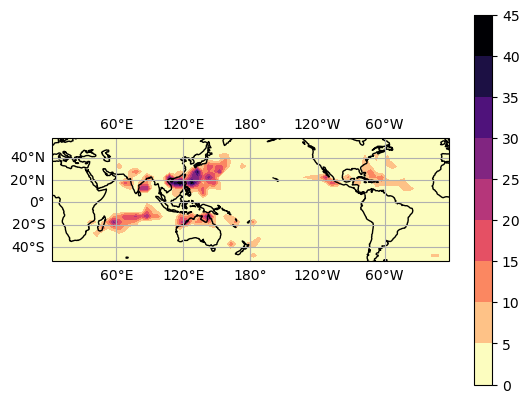

In [29]:
# You can plot the track density directly with `plot_density`, which is based on a simple 2D histogram of TC points
tracks.hrcn.plot_density()

In [30]:
# You can also get the underlying density matrix with `get_density` and then use it to make you own plots in your favourite way
tracks.hrcn.get_density()

<xarray.DataArray (lat: 22, lon: 67)> Size: 12kB
array([[0., 0., 0., ..., 0., 0., 3.],
       [2., 1., 0., ..., 6., 1., 0.],
       [0., 0., 0., ..., 1., 1., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 2., 1., 1.],
       [0., 0., 0., ..., 0., 0., 0.]])
Coordinates:
  * lon      (lon) float64 536B 2.5 7.5 22.5 27.5 ... 342.5 347.5 352.5 357.5
  * lat      (lat) float64 176B -52.5 -47.5 -42.5 -37.5 ... 42.5 47.5 52.5 57.5

#### Plotting genesis points

In [31]:
# `get_gen_vals` allows you to subset only the genesis points in an efficient way
gen_points = tracks.hrcn.get_gen_vals()
gen_points

Magnitude,[-1 -1 -1 -1 -1 0 -1 -1 -1 -1 -1 -1 -1 -1 0 -1 0 0 -1 -1 -1 -1 -1 -1 0 -1 0 -1 0 -1 -1 0 -1 -1 0 -1 0 -1 -1 -1 -1 -1 -1 -1 -1 0 -1 -1 -1 0 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 0 -1 -1 -1 -1 -1 -1 -1 -1]
Units,dimensionless


/Users/bourdin/Softs/huracanpy/huracanpy/plot/_tracks.py:41: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(


(<Figure size 1000x1000 with 1 Axes>, <GeoAxes: xlabel='lon', ylabel='lat'>)

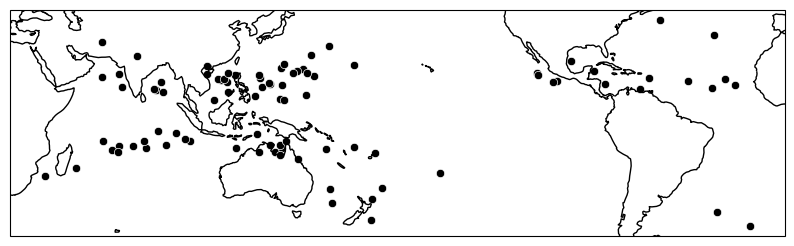

In [32]:
# If you use `plot_tracks` on these, you can display only the genesis points.
gen_points.hrcn.plot_tracks()

### 2d. Compute statistics

#### Number of cyclones

In [33]:
tracks.track_id.hrcn.nunique() # Count number of unique track ids

89

#### Cyclones duration & TC days

In [34]:
## Get the duration for each track
TC_duration = tracks.hrcn.get_track_duration() 
TC_duration # xarray.Dataset with track_id as dimension

<xarray.DataArray 'duration' (track_id: 89)> Size: 712B
array([162., 312.,  90., 126., 102., 126.,  96., 276.,  60.,  78., 252.,
       210., 174., 150.,  78., 180.,  66., 144., 186., 258.,  96.,  90.,
       246., 114., 114.,  84.,  72., 120., 276., 114.,  96.,  96.,  66.,
       258., 222., 312.,  78.,  72., 120., 150., 234., 324., 150.,  72.,
       354.,  54.,  96.,  90.,  96.,  90.,  90.,  84., 396., 342.,  66.,
       360., 120., 108., 114., 192., 144.,  84., 276., 198., 204., 240.,
       228., 144.,  78.,  60., 144., 330.,  66., 144., 210., 126., 294.,
        60., 204., 222.,  60., 198., 168., 144., 156., 216.,  90., 186.,
         0.])
Coordinates:
  * track_id  (track_id) float64 712B 1.207e+03 1.208e+03 ... 1.295e+03
Attributes:
    units:    hours

In [35]:
## Compute the total number of TC days
## Sum all the durations (and divide by 24 because durations are in hours)
TC_duration.sum() / 24

<xarray.DataArray 'duration' ()> Size: 8B
array(584.5)

#### Cyclone Intensity

In [36]:
# There are two ways to obtain the lifetime maximum intensity (LMI) of each tracks
## 1. Use `get_apex_vals`, which return the subset of points only as specified LMI
tracks.hrcn.get_apex_vals(varname = "wind10")

Magnitude,[ 0 0 0 0 0 0 -1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 -1 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 1 0 0 0 0 0 0 -1 0 0 0 0 1 0 0 1 0 -1 0 1 0 -1 1 0 0 1 0 0 0 0 0 1 0 0 0 -1 0 0 1 0 0 0 0 -1 0 0 0 0 -1]
Units,dimensionless


In [37]:
## 2. Compute lifetime maximum intensity per track with xarray's groupby
LMI_wind = tracks.groupby("track_id").max().wind10
LMI_wind # xarray.Dataset with track_id as dimension

/Users/bourdin/Softs/miniforge3/envs/huracanpy/lib/python3.11/site-packages/xarray/core/concat.py:540: UserWarning: No index created for dimension track_id because variable track_id is not a coordinate. To create an index for track_id, please first call `.set_coords('track_id')` on this object.
  ds.expand_dims(dim_name, create_index_for_new_dim=create_index_for_new_dim)


<xarray.DataArray 'wind10' (track_id: 89)> Size: 712B
array([19.52451, 26.59268, 17.80909, 18.41431, 18.83423, 18.77285,
       13.04252, 22.20843, 16.17976, 17.28381, 24.70252, 26.17307,
       23.33051, 20.3704 , 20.35412, 27.6403 , 23.506  , 29.57074,
       26.85967, 28.38823, 20.47431, 15.20365, 31.37127, 20.17752,
       21.74682, 20.17922, 20.41931, 23.31932, 22.55483, 16.30926,
       21.4158 , 24.05482, 16.89222, 22.89363, 29.23333, 21.58997,
       17.58261, 21.79618, 24.55191, 29.73219, 30.8955 , 23.70912,
       20.9533 , 16.77547, 26.01644, 17.29322, 18.71597, 15.63176,
       18.66206, 23.09372, 27.94086, 20.65676, 29.73094, 27.72158,
       19.62944, 34.28312, 16.19071, 14.36055, 28.84449, 30.7681 ,
       20.81133, 15.41807, 33.45812, 27.63117, 19.58178, 31.23918,
       26.30785, 26.97909, 21.70943, 17.36107, 19.78419, 30.04986,
       19.48046, 25.52096, 20.81055, 15.8441 , 26.90078, 19.07706,
       36.74792, 17.85815, 26.09754, 18.91639, 27.87503, 15.08413,
       26.1869 , 25.00324, 22.20926, 22.3301 , 11.57796])
Coordinates:
  * track_id  (track_id) float64 712B 1.207e+03 1.208e+03 ... 1.295e+03

(array([ 2.,  9., 15., 17., 14., 10., 10.,  9.,  1.,  2.]),
 array([11.57796 , 14.094956, 16.611952, 19.128948, 21.645944, 24.16294 ,
        26.679936, 29.196932, 31.713928, 34.230924, 36.74792 ]),
 <BarContainer object of 10 artists>)

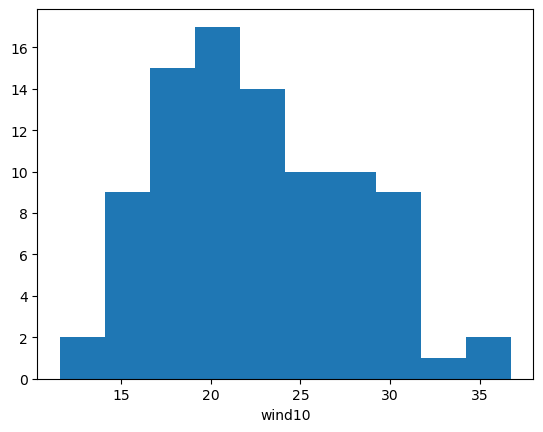

In [38]:
# You can then plot the LMI distribution using xarray's built-in plot function.
LMI_wind.plot.hist()

#### ACE

In [39]:
# Compute ACE for each point
tracks = tracks.hrcn.add_ace(wind_name = "wind10", wind_units = 'm s**-1')
tracks.ace

<xarray.DataArray 'ace' (record: 2274)> Size: 18kB
array([0.        , 0.        , 0.        , ..., 0.17286087, 0.16846039,
       0.        ])
Dimensions without coordinates: record
Attributes:
    units:    knot ** 2

In [40]:
## Compute total ACE
tracks.ace.sum()

<xarray.DataArray 'ace' ()> Size: 8B
array(210.18231953)

### 2e. Compositing lifecycle

In [41]:
# Add time from apex variable to be able to superimpose all the tracks centered on apex
tracks = tracks.hrcn.add_time_from_apex(intensity_var_name='slp', stat = "min") # Add time from minimum pressure
tracks.time_from_apex

<xarray.DataArray 'time_from_apex' (record: 2274)> Size: 18kB
array([-237600000000000, -216000000000000, -194400000000000, ...,
        259200000000000,  280800000000000,                0],
      dtype='timedelta64[ns]')
Dimensions without coordinates: record

<Axes: xlabel='time_from_apex', ylabel='slp'>

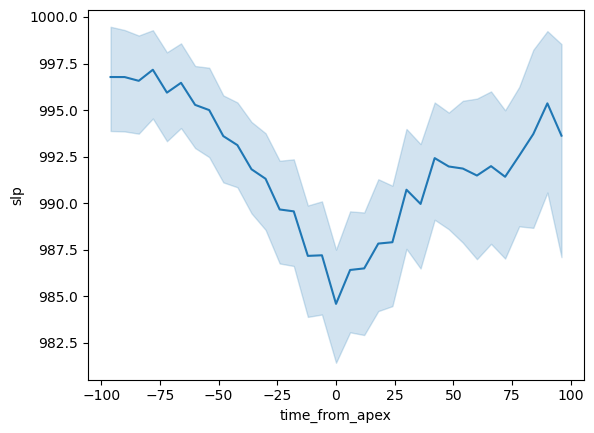

In [42]:
# Plot composite SLP lifecycle
## Convert time_from_apex to hours
tracks["time_from_apex"] = tracks.time_from_apex * 1e-9 / 3600
## Use xarray's where to mask points too far away from apex (100 hours away)
tracks_close_to_apex = tracks.where((tracks.time_from_apex >= -100) & (tracks.time_from_apex <= 100), drop = True)
## Seaborn lineplot allows for drawing composites with uncertainty range
sns.lineplot(x = tracks_close_to_apex.time_from_apex, # x-axis is time from apex
             y = tracks_close_to_apex.slp / 100,) # y-axis is slp, converted to hPa

## 3. Comparing two datasets
In this part, we compare the set of 1996 tracks above to IBTrACS which we use as reference. 
To start with, note that for all that was shown above, you can superimpose several sets and therefore compare several sources/models/trackers/etc. Below we show specific functions for matching tracks and computing detection scores.

### 3a. Data

In [45]:
# Remember IBTrACS is stored in the `ib` object from the first part above. 
# Here we subset the 1996 tracks with xarray's where method: 
ib_1996 = ib.where(ib.time.dt.year == 1996, drop = True)
ib_1996

<xarray.Dataset> Size: 276kB
Dimensions:   (record: 4313)
Dimensions without coordinates: record
Data variables:
    track_id  (record) object 35kB '1995357N07139' ... '1996365S15137'
    season    (record) float64 35kB 1.995e+03 1.995e+03 ... 1.997e+03 1.997e+03
    basin     (record) object 35kB 'WP' 'WP' 'WP' 'WP' ... 'SP' 'SI' 'SI' 'SI'
    time      (record) datetime64[ns] 35kB 1996-01-01 ... 1996-12-31T18:00:00
    lon       (record) float64 35kB 153.5 157.0 159.0 ... 134.6 134.1 133.8
    lat       (record) float64 35kB 26.0 27.0 27.5 28.0 ... -13.6 -13.2 -12.8
    wind      (record) float64 35kB nan nan nan nan nan ... nan nan nan nan nan
    slp       (record) float64 35kB 1.008e+03 1.006e+03 1.006e+03 ... nan nan

In [46]:
# The tracks from ERA5 are stored in `tracks`. For clarity, we name it `ERA5` from now:
ERA5 = tracks.copy()

### 3b. Superimposing several sets on one plot
To start with, note that for all that was shown above, you can superimpose several sets and therefore compare several sources/models/trackers/etc. Here we only show one example.

/Users/bourdin/Softs/miniforge3/envs/huracanpy/lib/python3.11/site-packages/xarray/core/concat.py:540: UserWarning: No index created for dimension track_id because variable track_id is not a coordinate. To create an index for track_id, please first call `.set_coords('track_id')` on this object.
  ds.expand_dims(dim_name, create_index_for_new_dim=create_index_for_new_dim)
/Users/bourdin/Softs/miniforge3/envs/huracanpy/lib/python3.11/site-packages/xarray/core/concat.py:540: UserWarning: No index created for dimension track_id because variable track_id is not a coordinate. To create an index for track_id, please first call `.set_coords('track_id')` on this object.
  ds.expand_dims(dim_name, create_index_for_new_dim=create_index_for_new_dim)


Text(0, 0.5, 'Number of tracks')

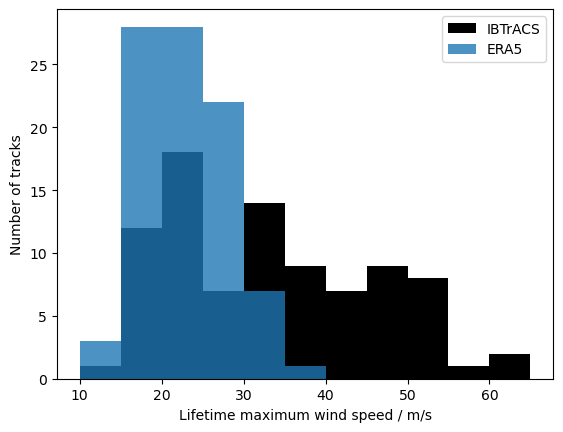

In [69]:
# Compute LMI for both sets
LMI_wind_ib = ib_1996.groupby("track_id").max().wind
LMI_wind_ib = LMI_wind_ib / 1.94 # Convert kn to m/s
LMI_wind_ERA5 = ERA5.groupby("track_id").max().wind10
# Plot both histograms
LMI_wind_ib.plot.hist(bins = [10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65], color = 'k', label = "IBTrACS")
LMI_wind_ERA5.plot.hist(bins = [10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65], label = "ERA5", alpha = 0.8)
# Labels
plt.legend()
plt.xlabel("Lifetime maximum wind speed / m/s")
plt.ylabel("Number of tracks")

### 3c. Matching tracks

In [75]:
matches = huracanpy.assess.match([ERA5, ib_1996], names = ["ERA5", "IBTrACS"])
matches # each row is a pair of tracks that matched, with both ids, the number of time steps and the mean distance between the tracks over their matching period.

,id_ERA5,id_IBTrACS,temp,dist
0,1207.0,1996002S15133,27,48.531963
1,1208.0,1996001S08075,39,39.697687
2,1209.0,1996007S10100,13,80.979701
3,1210.0,1996015S18182,13,104.460676
4,1213.0,1996021S16152,11,70.118845
...,...,...,...,...
72,1291.0,1996353N05151,26,64.419466
73,1292.0,1996357S10136,30,96.003139
74,1293.0,1996356N08110,13,98.513440
75,1294.0,1996354S05170,32,86.234183


### 3d. Computing scores

In [77]:
# Probability of detection (POD) : Proportion of observed tracks that are found in ERA5.
huracanpy.assess.pod(matches, ref = ib_1996, ref_name = "IBTrACS")

0.635593220338983

In [78]:
# False alarm rate (FAR) : Proportion of detected tracks that were not observed
huracanpy.assess.far(matches, detected = ERA5, detected_name = "ERA5")

0.1460674157303371

### 3e. Venn diagrams
Venn diagrams are a convenient way to show the overlap between two datasets.

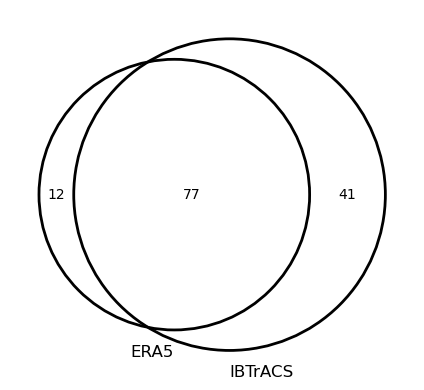

In [79]:
huracanpy.plot.venn([ERA5, ib_1996], matches, labels = ["ERA5", "IBTrACS"])